# Intro

In [27]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb

Your file on your github needs to be a a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U6proj.

Ex1.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU7proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU7proj.ipynb"

# Unit 7 Project: Polynomials, Splines, and GPs, Oh my!

**Task**:

Two parts:

1. Propose a data set that's compatible with pymc and/or bambi. I must approve your submission before you move on to part 2.

2. Create, analyze, and present any guassian process or approximate GP, degenerate or otherwise (this means glms and b splines are allowed), using pymc within the colab environment, on a data set of your choice, with the following conditions:
  - your final model must have more than 2 predictors. The intercept term doesn't count as a predictor here (even though technically it is), or if must be an actual GP
  - You must document and explain your model selection method. This means you must argue that your model choice (glm, b spline, GP) is better than at least one other choice. You may use either a theoretical or numerical argument.



Guidlines:

- Your data or your model type must be different from any project you've previously done.

- You are allowed to copy and paste any code from the notes, including my answer key (AK), without any reference or citations. Same goes for the course textbook, BAP3.

- This is an individual project. It is fine if you model the same process as a peer, but your raw data **must** be substantially different. "Substantially different" means that I, your instructor, arbitrarily think your data sets are different enough.

- Do not look at other student's code/jupyter notebooks. Copying, or copying and pasting, other students code will result in a failing grade. Also, I will tell all the other teachers I know that you cheated.

- If you want to know what another student did, ask them--any verbal communication about a project is allowed and encouraged. If you want to see a graphic they made, ask them to sketch a picture of it for you by hand.

- Any handwritten communication is also allowed and encouraged, so long as all parties are in the same physical location together. Example: you may sketch out a piece of code while verbally explaining to someone what you did. Do NOT: hand write the code for your entire project, take a picture, and send it to everyone in the course.

- If you use someone's code from outside this course (like from the internet, an AI, or your parent), you must ask me if it is ok, and you must cite them in your work. I don't care all they did was to click your space bar one more time: you tell me, and you cite their contribution. You don't need to tell me about or cite verbal or handwritten communication though.

- You may use a more complicated model--like something from further along in the course--IF I give you permission.

- If you are unsure whether or not something is ok or allowed: ASK BEFORE YOU DO IT.

Faliure to adhere to these guidlines will result in a failing grade.

Tips:

- Try to pick something that you care about, have knowledge of, experience with, or that you find interesting/cool.

- Gather data *before* picking a model or likelihood.

-  Use your best idea now; maybe you can look at the context you used in the previous project, and gather different data from it.

- Choose a data set with lots of columns, and lots of potential interactions between variables. It'll be more fun, and will make model/variable selection more relevant.

- This is not a competition to come up with the fanciest model structure. Find a data set that interests you, and apply the simplest model that captures the patterns in the data.

- Comment heavily, and explain your steps and thought process with text blocks. This is not only requried, it'll also help you understand what you're doing and what you want to do.

- I actually encourge you to use b splines; they work quite well, and trying to determine the location of the knots requires careful thought about the context of the data.

- Its ok to pick a data set for which you don't qute understand the context--so long as you think the context is cool.


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/cyrus-rule/Data-Science-/refs/heads/main/biketrips.csv')

In [4]:
data

,days,minutes,tripduration,from_station_name,to_station_name
0,180,1437,604,Lincoln Ave & Belmont Ave,Broadway & Cornelia Ave
1,180,1436,263,Halsted St & Maxwell St,May St & Taylor St
2,180,1413,126,Sheffield Ave & Webster Ave,Halsted St & Dickens Ave
3,180,1406,3481,Peoria St & Jackson Blvd,State St & Wacker Dr
4,180,1396,638,Loomis St & Lexington St,Peoria St & Jackson Blvd
...,...,...,...,...,...
86780,174,1,1603,Cannon Dr & Fullerton Ave,Theater on the Lake
86781,174,0,1603,Cannon Dr & Fullerton Ave,Theater on the Lake
86782,174,0,753,California Ave & North Ave,Kedzie Ave & Milwaukee Ave
86783,174,0,5529,Clark St & Chicago Ave,Sheridan Rd & Lawrence Ave


In [7]:
%pip install geopy
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="bike_rental_model")

def get_coordinates(station_name, max_retries=2):
    for attempt in range(max_retries):
        try:
            location = geolocator.geocode(f"{station_name}, Chicago, IL", timeout=10)
            if location:
                return (location.latitude, location.longitude)
            else:
                return (None, None)
        except:
            return (None, None)

station_name = "Lincoln Ave & Leavitt St"
print(get_coordinates(station_name))


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
(None, None)


In [8]:
unique_stations = pd.concat([data['from_station_name'], data['to_station_name']]).unique()

In [9]:
unique_stations

array(['Lincoln Ave & Belmont Ave', 'Halsted St & Maxwell St',
       'Sheffield Ave & Webster Ave', 'Peoria St & Jackson Blvd',
       'Loomis St & Lexington St', 'Halsted St & Diversey Pkwy',
       'Canal St & Madison St', 'Wabash Ave & Grand Ave',
       'Larrabee St & Armitage Ave', 'Ravenswood Ave & Montrose Ave',
       'State St & 19th St', 'Canal St & Harrison St',
       'Orleans St & Merchandise Mart Plaza', 'Lake Park Ave & 47th St',
       'Museum Campus', 'Clark St & Congress Pkwy',
       'Ashland Ave & Division St', 'Aberdeen St & Madison St',
       'Franklin St & Chicago Ave', 'Racine Ave & Belmont Ave',
       'LaSalle St & Illinois St', 'Wells St & Concord Ln',
       'Michigan Ave & Congress Pkwy', 'McClurg Ct & Illinois St',
       'Michigan Ave & Pearson St', 'Mies van der Rohe Way & Chicago Ave',
       'Ashland Ave & Augusta Blvd', 'Theater on the Lake',
       'Fairbanks Ct & Grand Ave', 'Franklin St & Arcade Pl',
       'Sheridan Rd & Irving Park Rd', 'Wells 

In [ ]:
station_coords = {}
for station in unique_stations:
    try:
        station_coords[station] = get_coordinates(station)
    except:
        station_coords[station] = (0, 0)
    time.sleep(1)

In [ ]:
failed_coords = {}
for station, coords in station_coords.items():
    if coords == (None, None):
        failed_coords[station] = coords

In [ ]:
failed_coords

{'Halsted St & Diversey Pkwy': (None, None),
 'Clark St & Congress Pkwy': (None, None),
 'Michigan Ave & Congress Pkwy': (None, None),
 'Franklin St & Arcade Pl': (None, None),
 'May St & Randolph St': (None, None),
 'Halsted St & James M Rochford St': (None, None),
 'Lincoln Ave & Leavitt St': (None, None),
 'Wabash Ave & 8th St': (None, None),
 'Wood St & Division St': (None, None),
 'Halsted St & Blackhawk St': (None, None),
 'Clark St & Waveland Ave': (None, None),
 'Wells St & Erie St': (None, None),
 'Halsted St & Waveland Ave': (None, None),
 'Shore Drive & 55th St': (None, None),
 'Martin Luther King Dr & 29th St': (None, None),
 'Morgan Ave & 14th Pl': (None, None),
 'Cityfront Plaza & N Water St': (None, None),
 'State St & Erie St': (None, None),
 'Hampden Ct & Diversey Pkwy': (None, None),
 'Sheffield Ave & Addison St': (None, None),
 'Canal St & Monroe St': (None, None),
 'Leavitt St & Hirsch St': (None, None),
 'Marshfield Ave & Cortland St': (None, None),
 'Lincoln Ave &

In [ ]:
station_coords['Halsted St & Diversey Pkwy'] = (41.933524085111316, -87.64906976642908)
station_coords['Clark St & Congress Pkwy'] = (41.87655110680505, -87.63089821249358)
station_coords['Michigan Ave & Congress Pkwy'] = (41.87638767251824, -87.62445464317649)
station_coords['Franklin St & Arcade Pl'] = (41.881929330510225, -87.63548545851417)
station_coords['May St & Randolph St'] = (41.884808691957375, -87.6556910818046)
station_coords['Halsted St & James M Rochford St'] = (41.86636802981053, -87.64695128181751)
station_coords['Lincoln Ave & Leavitt St'] = (41.96193398243927, -87.68362050504314)
station_coords['Wabash Ave & 8th St'] = (41.87236979771138, -87.62592955113041)
station_coords['Wood St & Division St'] = (41.90397643248606, -87.6724796817913)
station_coords['Halsted St & Blackhawk St'] = (41.909179760845575, -87.64821705110462)
station_coords['Clark St & Waveland Ave'] = (41.94960557634526, -87.65804078175913)
station_coords['Wells St & Erie St'] = (41.89463024453914, -87.6342201817978)
station_coords['Halsted St & Waveland Ave'] = (41.94979311013272, -87.64964008175903)
station_coords['Shore Drive & 55th St'] = (41.79567997013598, -87.58083885118413)
station_coords['Martin Luther King Dr & 29th St'] = (41.842841847672865, -87.61729568183424)
station_coords['Morgan Ave & 14th Pl'] = (41.862954222598155, -87.65098178182005)
station_coords['Cityfront Plaza & N Water St'] = (41.89070044727213, -87.62188618180043)
station_coords['State St & Erie St'] = (41.894561818296786, -87.62852428918804)
station_coords['Hampden Ct & Diversey Pkwy'] = (41.933395778631386, -87.64239370506313)
station_coords['Sheffield Ave & Addison St'] = (41.94794924825625, -87.6540685590286)
station_coords['Canal St & Monroe St'] = (41.881004715799826, -87.63983341249012)
station_coords['Leavitt St & Hirsch St'] = (41.90736167813068, -87.68220603576442)
station_coords['Marshfield Ave & Cortland St'] = (41.91660368718168, -87.66903133575786)
station_coords['Lincoln Ave & Eastwood Ave'] = (41.9662523989026, -87.6868143124303)
station_coords['Wood St & North Ave'] = (41.91123251550038, -87.67258325110319)
station_coords['Green St & Milwaukee Ave'] = (41.89245613409787, -87.64872622043328)
station_coords['Clifton Ave & Lawrence Ave'] = (41.96974180812307, -87.6588499357206)
station_coords['Franklin St & Quincy St'] = (41.879091675196555, -87.63531518180854)
station_coords['Ashland Ave & 21st St'] = (41.85461005267431, -87.66606898182572)
station_coords['Wood St & Grand Ave'] = (41.89132784867051, -87.67228054316581)
station_coords['Wallace Ave & 35th St'] = (41.831556506035014, -87.64115392047624)
station_coords['Paulina St & Diversey Pkwy'] = (41.93301696033661, -87.67082795108789)
station_coords['Martin Luther King Dr & Oakwood Blvd'] = (41.823033811467795, -87.61683259718936)


In [ ]:
station_coords

{'Lincoln Ave & Belmont Ave': (41.9393041, -87.6682778),
 'Halsted St & Maxwell St': (41.8648187, -87.6471285),
 'Sheffield Ave & Webster Ave': (41.921687, -87.653714),
 'Peoria St & Jackson Blvd': (41.8777021, -87.6496545),
 'Loomis St & Lexington St': (41.8721652, -87.6614337),
 'Halsted St & Diversey Pkwy': (41.933524085111316, -87.64906976642908),
 'Canal St & Madison St': (41.881654499999996, -87.6395711762474),
 'Wabash Ave & Grand Ave': (41.8914225, -87.6267774),
 'Larrabee St & Armitage Ave': (41.9180783, -87.6437469),
 'Ravenswood Ave & Montrose Ave': (41.9614245, -87.6762198),
 'State St & 19th St': (41.856594, -87.627542),
 'Canal St & Harrison St': (41.8742451, -87.6395767),
 'Orleans St & Merchandise Mart Plaza': (41.8883141, -87.6364539),
 'Lake Park Ave & 47th St': (41.80943, -87.5918871),
 'Museum Campus': (41.8685933, -87.6156365),
 'Clark St & Congress Pkwy': (41.87655110680505, -87.63089821249358),
 'Ashland Ave & Division St': (41.903455, -87.66788),
 'Aberdeen St &

In [ ]:
data['from_coords'] = data['from_station_name'].apply(lambda x: station_coords[x])
data['to_coords'] = data['to_station_name'].apply(lambda x: station_coords[x])

In [ ]:
data

,days,minutes,tripduration,from_station_name,to_station_name,from_coords,to_coords
0,180,1437,604,Lincoln Ave & Belmont Ave,Broadway & Cornelia Ave,"(41.9393041, -87.6682778)","(41.9455138, -87.6464769)"
1,180,1436,263,Halsted St & Maxwell St,May St & Taylor St,"(41.8648187, -87.6471285)","(41.8693885, -87.6554754)"
2,180,1413,126,Sheffield Ave & Webster Ave,Halsted St & Dickens Ave,"(41.921687, -87.653714)","(41.919936, -87.64883)"
3,180,1406,3481,Peoria St & Jackson Blvd,State St & Wacker Dr,"(41.8777021, -87.6496545)","(41.88782981167939, -87.6280594929474)"
4,180,1396,638,Loomis St & Lexington St,Peoria St & Jackson Blvd,"(41.8721652, -87.6614337)","(41.8777021, -87.6496545)"
...,...,...,...,...,...,...,...
86780,174,1,1603,Cannon Dr & Fullerton Ave,Theater on the Lake,"(41.926752, -87.634457)","(41.9262421, -87.6309574)"
86781,174,0,1603,Cannon Dr & Fullerton Ave,Theater on the Lake,"(41.926752, -87.634457)","(41.9262421, -87.6309574)"
86782,174,0,753,California Ave & North Ave,Kedzie Ave & Milwaukee Ave,"(41.9104606, -87.6969033)","(41.92958995, -87.70790961887985)"
86783,174,0,5529,Clark St & Chicago Ave,Sheridan Rd & Lawrence Ave,"(41.8967397, -87.6307486)","(41.969517, -87.654691)"


In [ ]:
data.to_csv('biketrips_with_coordinates.csv', index=False)

from google.colab import files
files.download('biketrips_with_coordinates.csv')


NameError: name 'data' is not defined

# Data

In [28]:
data = pd.read_csv('https://raw.githubusercontent.com/cyrus-rule/Data-Science-/refs/heads/main/biketrips_with_coordinates.csv')

In [29]:
station_coords = {}
for index, row in data.iterrows():
    station_name = row['from_station_name']
    if station_name not in station_coords:
        coords_str = row['from_coords'].strip('()').split(', ')
        latitude = float(coords_str[0])
        longitude = float(coords_str[1])
        station_coords[station_name] = (latitude, longitude)

<Axes: >

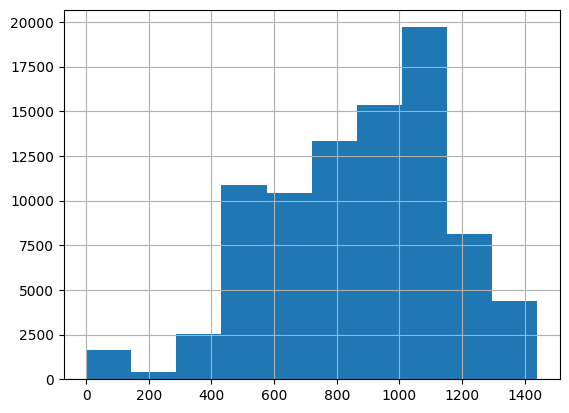

In [30]:
data.minutes.hist()

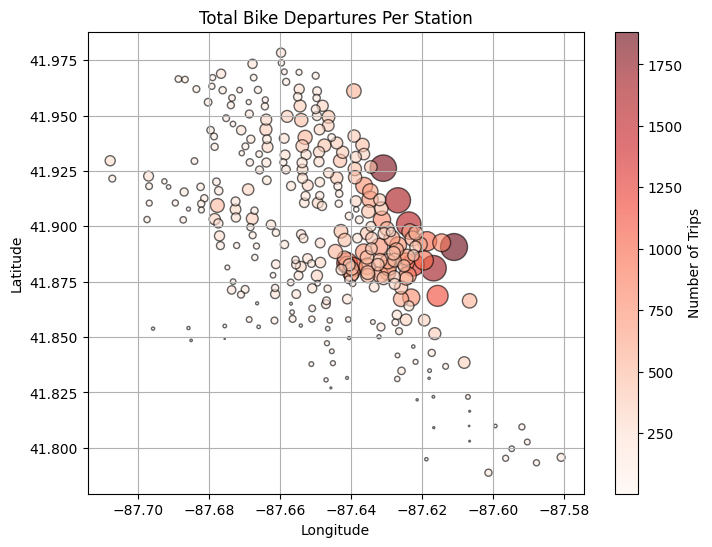

In [31]:
# Count trips per station
station_trip_counts = data['from_station_name'].value_counts()
stations = pd.DataFrame({'station': station_trip_counts.index, 'trips': station_trip_counts.values})

# Merge with coordinates
stations['coords'] = stations['station'].map(station_coords)
stations[['latitude', 'longitude']] = stations['coords'].apply(lambda x: pd.Series(x))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(stations['longitude'], stations['latitude'], s=stations['trips']/5, alpha=0.6, c=stations['trips'], cmap='Reds', edgecolors="black")
plt.colorbar(label="Number of Trips")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Total Bike Departures Per Station")
plt.grid(True)
plt.show()

In [32]:
import folium
import branca.colormap as cm
# Get the center of the map
map_center = [stations['latitude'].mean(), stations['longitude'].mean()]

# Create map with folium
m = folium.Map(location=map_center, zoom_start=12)

# Create color scale
colormap = cm.linear.YlOrRd_09.scale(stations['trips'].min(), stations['trips'].max())

# Normalize trip counts for marker size
max_trips = stations['trips'].max()

# Add circles for each station
for _, row in stations.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5 + (row['trips'] / max_trips) * 15,  # Scale size
        color=colormap(row['trips']),  # Color based on trips
        fill=True,
        fill_color=colormap(row['trips']),
        fill_opacity=0.7,
        popup=f"{row['station']}: {row['trips']} trips",
    ).add_to(m)

# Add color legend
colormap.caption = "Number of Trips"
colormap.add_to(m)

# Display the map
m

# Models

In [33]:
#aggregate trips from the same station and time of day

grouped = data.groupby(['from_station_name', 'minutes']).size().reset_index(name='trips')

#put in coordinates

grouped['coords'] = grouped['from_station_name'].apply(lambda x: station_coords[x])
grouped[['latitude', 'longitude']] = grouped['coords'].apply(lambda x: pd.Series(x))

In [34]:
# Input Matrix
X = grouped[['minutes', 'latitude', 'longitude']].values
# Output matrix
y = grouped['trips'].values

In [35]:

# with pm.Model() as gp_model:
#     # Hyperparameters for the time kernel (but set full input_dim=3)
#     ls_time = pm.Gamma("ls_time", alpha=2, beta=1)
#     period = 1440  # minutes in a day
#     cov_time = pm.gp.cov.Periodic(3, ls=ls_time, period=period, active_dims=[0])
#
#     # Hyperparameters for the spatial kernel (also set input_dim=3)
#     ls_space = pm.Gamma("ls_space", alpha=2, beta=1)
#     cov_space = pm.gp.cov.Matern52(3, ls=ls_space, active_dims=[1, 2])
#
#     # Now multiply the kernels; they both think they are defined on a 3-dimensional space.
#     cov = cov_time * cov_space
#
#     # Create the GP object
#     gp = pm.gp.Marginal(cov_func=cov)
#
#     sigma = pm.HalfCauchy("sigma", beta=5)
#     y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma)
#
#     trace = pm.sample(500, tune=500, target_accept=0.9)


In [36]:
# m = 100
# # Choose inducing points, for example by subsampling or using k-means on your inputs X.
# X_u = X[np.random.choice(X.shape[0], size=m, replace=False)]
#
# with pm.Model() as gp_model:
#     ls_time = pm.Gamma("ls_time", alpha=2, beta=1)
#     period = 1440  # minutes in a day
#     cov_time = pm.gp.cov.Periodic(3, ls=ls_time, period=period, active_dims=[0])
#
#     ls_space = pm.Gamma("ls_space", alpha=2, beta=1)
#     cov_space = pm.gp.cov.Matern52(3, ls=ls_space, active_dims=[1, 2])
#
#     cov = cov_time * cov_space
#
#     # Use a sparse GP approximation
#     gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")
#
#     sigma = pm.HalfCauchy("sigma", beta=5)
#
#     # Pass the inducing inputs as X_u
#     y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma, Xu=X_u)
#
#     trace = pm.sample(500, tune=500, target_accept=0.9)

In [37]:
grouped['time_bin'] = (grouped['minutes'] // 30) * 30


In [38]:
grouped = grouped.groupby(['from_station_name', 'time_bin']).agg({
    'trips': 'sum',
    'coords': 'first',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()


In [39]:
grouped

,from_station_name,time_bin,trips,coords,latitude,longitude
0,900 W Harrison,0,1,"(41.8743102, -87.6494554)",41.874310,-87.649455
1,900 W Harrison,60,1,"(41.8743102, -87.6494554)",41.874310,-87.649455
2,900 W Harrison,510,4,"(41.8743102, -87.6494554)",41.874310,-87.649455
3,900 W Harrison,540,4,"(41.8743102, -87.6494554)",41.874310,-87.649455
4,900 W Harrison,570,2,"(41.8743102, -87.6494554)",41.874310,-87.649455
...,...,...,...,...,...,...
10431,Woodlawn Ave & 55th St,1170,2,"(41.795264, -87.596471)",41.795264,-87.596471
10432,Woodlawn Ave & 55th St,1200,1,"(41.795264, -87.596471)",41.795264,-87.596471
10433,Woodlawn Ave & 55th St,1260,2,"(41.795264, -87.596471)",41.795264,-87.596471
10434,Woodlawn Ave & 55th St,1290,1,"(41.795264, -87.596471)",41.795264,-87.596471


In [40]:
# m = 100
# X_u = X[np.random.choice(X.shape[0], size=m, replace=False)]
#
# with pm.Model() as gp_model:
#     ls_time = pm.Gamma("ls_time", alpha=2, beta=1)
#     period = 1440  # minutes in a day
#     cov_time = pm.gp.cov.Periodic(3, ls=ls_time, period=period, active_dims=[0])
#
#     ls_space = pm.Gamma("ls_space", alpha=2, beta=1)
#     cov_space = pm.gp.cov.Matern52(3, ls=ls_space, active_dims=[1, 2])
#
#     cov = cov_time * cov_space
#
#     # Use a sparse GP approximation
#     gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")
#
#     sigma = pm.HalfCauchy("sigma", beta=5)
#
#     # Pass the inducing inputs as X_u
#     y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma, Xu=X_u)
#
#     trace = pm.sample(500, tune=500, target_accept=0.9)

I tried to save this model using pickle and it did not work (My model had much less predictive power after being saved)

In [41]:
import pickle
import cloudpickle


In [42]:
# import cloudpickle
#
# with open('gp_model.pkl', 'wb') as buff:
#     cloudpickle.dump({'model': gp_model, 'trace': trace}, buff)

In [43]:
# with open('gp_model.pkl', 'rb') as buff:
#    data1 = pickle.load(buff) # loads the pickled dictionary to data1
#    gp_model1 = data1['model'] # Accesses the 'model' key from the dictionary data1
#    trace1 = data1['trace']    # Accesses the 'trace' key from the dictionary data1

In [44]:
# gp_model

In [45]:
# gp_model1

Post Pickle
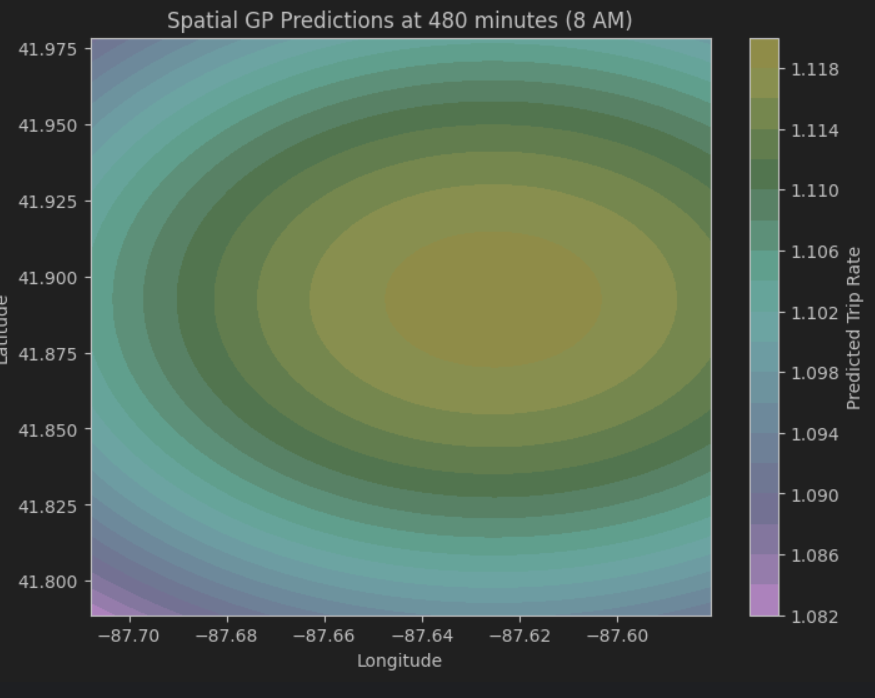
Pre Pickle
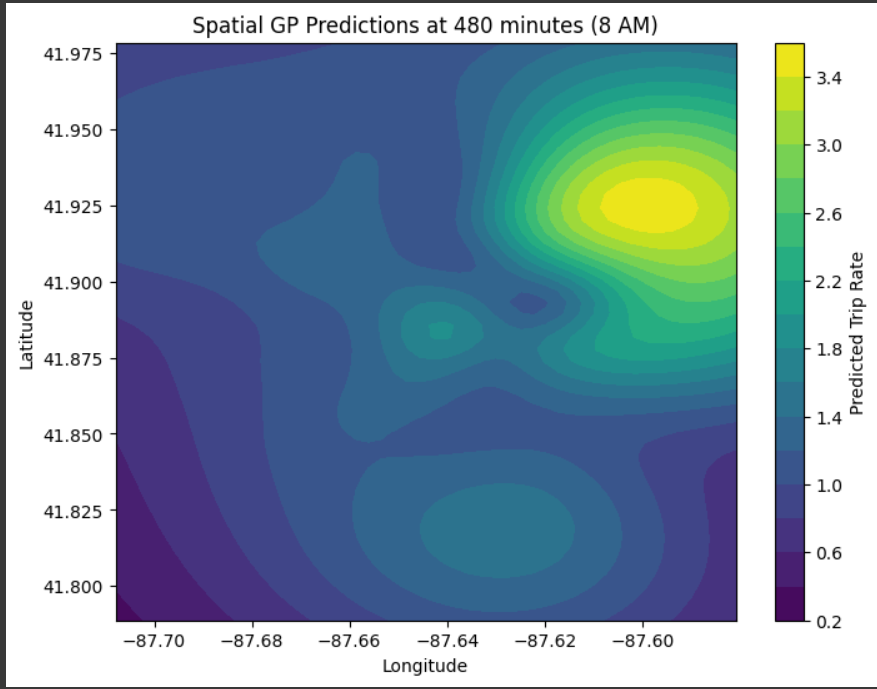

Post Pickle

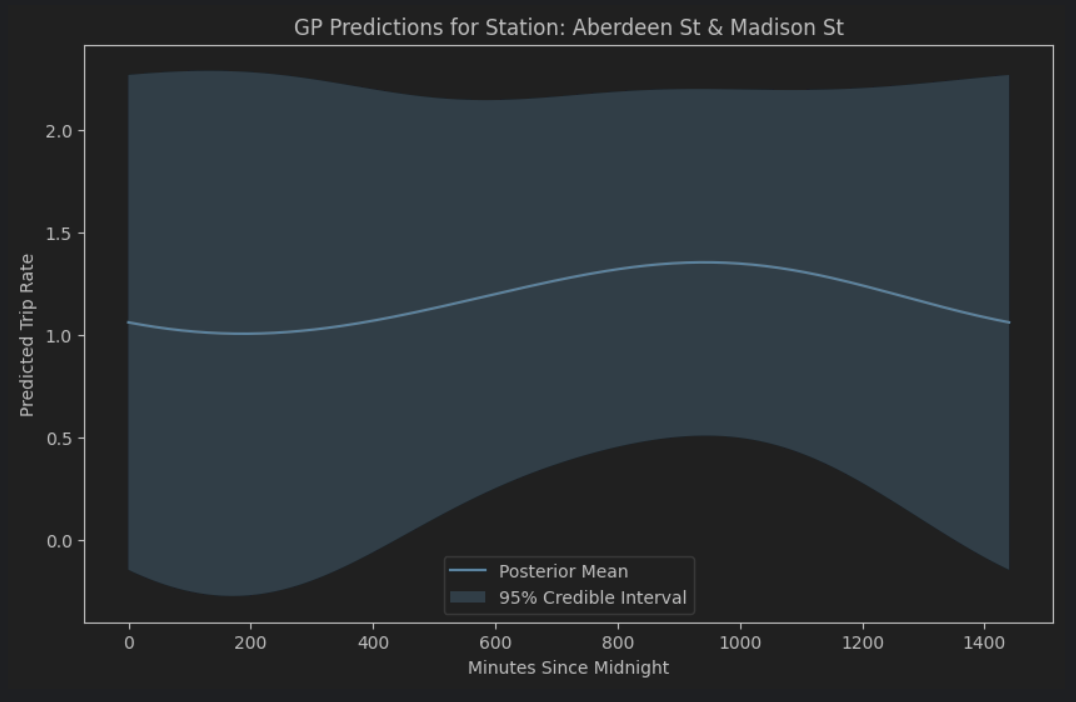

Welp, lets make it again and try not to lose it this time

In [ ]:
m = 100
X_u = X[np.random.choice(X.shape[0], size=m, replace=False)]

with pm.Model() as gp_model:
    ls_time = pm.Gamma("ls_time", alpha=2, beta=1)
    period = 1440  # minutes in a day
    cov_time = pm.gp.cov.Periodic(3, ls=ls_time, period=period, active_dims=[0])

    ls_space = pm.Gamma("ls_space", alpha=2, beta=1)
    cov_space = pm.gp.cov.Matern52(3, ls=ls_space, active_dims=[1, 2])

    cov = cov_time * cov_space

    # Use a sparse GP approximation
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

    sigma = pm.HalfCauchy("sigma", beta=5)

    # Pass the inducing inputs as X_u
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma, Xu=X_u)

    trace = pm.sample(200, tune=200, target_accept=0.9, mp_ctx="threadpool")


C:\Users\gamep\anaconda3\envs\Conda\lib\site-packages\pymc\gp\gp.py:896: FutureWarning: gp.MarginalSparse has been renamed to gp.MarginalApprox.
  warnings.warn(
C:\Users\gamep\anaconda3\envs\Conda\lib\site-packages\pymc\gp\gp.py:54: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


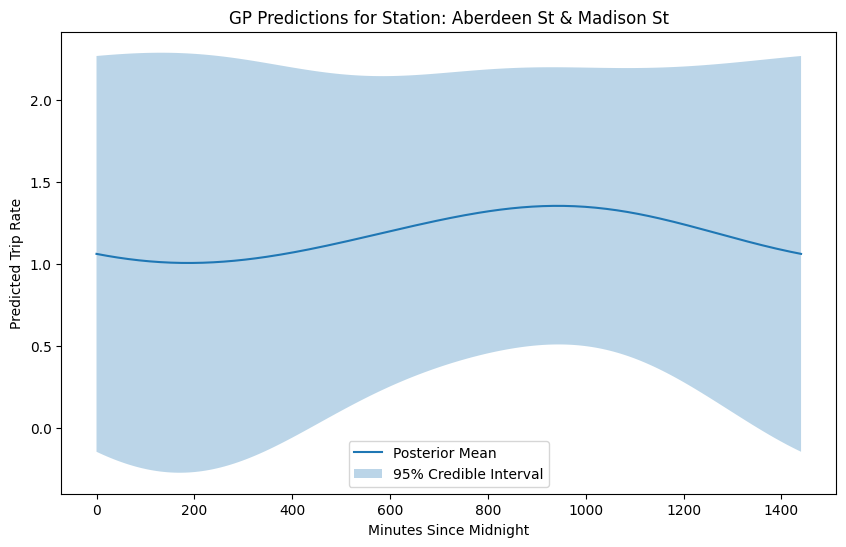

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose your station and get its coordinates (assuming station_coords dictionary exists)
station = "Aberdeen St & Madison St"
station_lat, station_lon = station_coords[station]

# Create a grid of times (in minutes since midnight)
time_grid = np.linspace(0, 1440, 200)  # 200 points across the day

# Build new input array for predictions: each row is [time, latitude, longitude]
new_X_time = np.column_stack([
    time_grid,
    np.full_like(time_grid, station_lat),
    np.full_like(time_grid, station_lon)
])

# Predict using your GP
# Instead of using the mean directly, use the mean of each parameter
# to create a representative point for prediction.
with gp_model:
    point = {
        "ls_time": trace.posterior["ls_time"].mean().item(),  # item() to get scalar value
        "ls_space": trace.posterior["ls_space"].mean().item(), # item() to get scalar value
        "sigma": trace.posterior["sigma"].mean().item() # Include sigma in the point dictionary
        # ... any other parameters in your model ...
    }
    pred_mean, pred_var = gp.predict(new_X_time, point=point, diag=True)

pred_std = np.sqrt(pred_var)

# Plot the GP predictions with uncertainty bands
plt.figure(figsize=(10, 6))
plt.plot(time_grid, pred_mean, label="Posterior Mean")
plt.fill_between(time_grid, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.3, label="95% Credible Interval")
plt.xlabel("Minutes Since Midnight")
plt.ylabel("Predicted Trip Rate")
plt.title(f"GP Predictions for Station: {station}")
plt.legend()
plt.show()

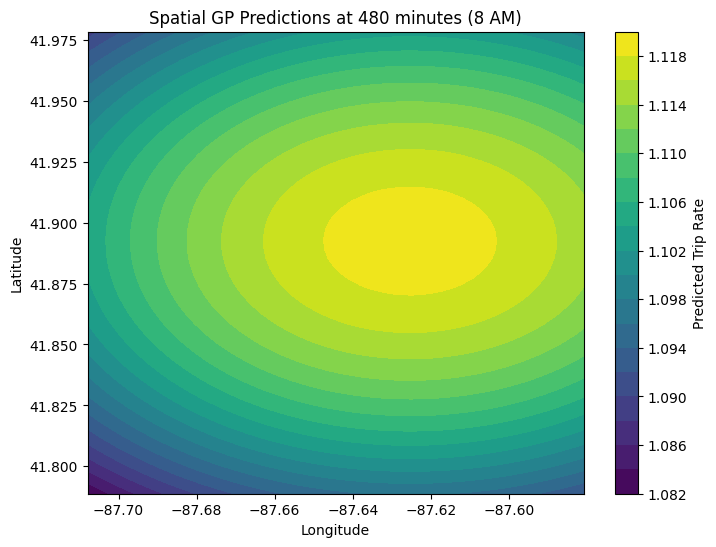

In [ ]:
import matplotlib.pyplot as plt

# Fix a time, e.g., 8 AM (480 minutes)
fixed_time = 480

# Define the spatial grid bounds using your data
lat_min, lat_max = grouped["latitude"].min(), grouped["latitude"].max()
lon_min, lon_max = grouped["longitude"].min(), grouped["longitude"].max()

# Create grid points (adjust grid_size for resolution)
grid_size = 50
lat_grid = np.linspace(lat_min, lat_max, grid_size)
lon_grid = np.linspace(lon_min, lon_max, grid_size)
lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)

# Flatten the grid to create input for GP predictions:
# Each input is [fixed_time, latitude, longitude]
new_X_space = np.column_stack([
    np.full(lat_mesh.flatten().shape, fixed_time),
    lat_mesh.flatten(),
    lon_mesh.flatten()
])

with gp_model:
    # Create a dictionary with the mean values of the parameters
    point = {
        "ls_time": trace.posterior["ls_time"].mean().item(),
        "ls_space": trace.posterior["ls_space"].mean().item(),
        "sigma": trace.posterior["sigma"].mean().item()
    }
    # Change 'axis=0' to 'dim="chain"' or the appropriate dimension name
    # Assuming your trace has a dimension named "chain"
    spatial_pred_mean, spatial_pred_var = gp.predict(new_X_space, point=point, diag=True)

# Reshape spatial_pred_mean to 2D
spatial_pred_mean = spatial_pred_mean.reshape(lat_mesh.shape)


# Plot a filled contour map (heatmap)
plt.figure(figsize=(8, 6))
contour = plt.contourf(lon_mesh, lat_mesh, spatial_pred_mean, cmap='viridis', levels=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Spatial GP Predictions at {fixed_time} minutes (8 AM)")
plt.colorbar(contour, label="Predicted Trip Rate")
plt.show()

It seems like the mistake may have been in the way I handled my pickled model. This may be recoverable.

In [25]:
# with open('gp_model.pkl', 'rb') as buff:
#    data1 = pickle.load(buff) # loads the pickled dictionary to data1
#    gp_model1 = data1['model'] # Accesses the 'model' key from the dictionary data1
#    trace1 = data1['trace']    # Accesses the 'trace' key from the dictionary data1

EOFError: Ran out of input